In [48]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from highlight_text import fig_text, ax_text
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def compute_duration(start_str, end_str):
    fmt = '%H:%M:%S'
    start = datetime.strptime(start_str, fmt)
    end = datetime.strptime(end_str, fmt)
    duration = (end - start).total_seconds() / 60
    return duration

df_2023 = pd.read_csv('eclipse_annular_2023.csv')
df_2024 = pd.read_csv('eclipse_total_2024.csv')
df_2023['duration'] = df_2023.apply(lambda row: compute_duration(
    row['eclipse_3'],
    row['eclipse_4']),
    axis=1
)
df_2024['duration'] = df_2024.apply(lambda row: compute_duration(
    row['eclipse_3'],
    row['eclipse_4']),
    axis=1
)

norm = Normalize(vmin=df_2023['duration'].min(), vmax=df_2023['duration'].max())
cmap2023 = plt.get_cmap('summer')
cmap2024 = plt.get_cmap('autumn')
sm2023 = ScalarMappable(norm=norm, cmap=cmap2023)
sm2024 = ScalarMappable(norm=norm, cmap=cmap2024)
df_2023['color'] = df_2023['duration'].apply(lambda x: sm2023.to_rgba(x))
df_2024['color'] = df_2024['duration'].apply(lambda x: sm2024.to_rgba(x))

# color for each year
avg_duration_2023 = df_2023['duration'].mean()
col_2023 = sm2023.to_rgba(avg_duration_2023)
avg_duration_2024 = df_2024['duration'].mean()
col_2024 = sm2024.to_rgba(avg_duration_2024)

df_2023.to_csv('../../../../The-Python-Graph-Gallery/static/data/eclipse_annular_2023.csv', index=False)
df_2024.to_csv('../../../../The-Python-Graph-Gallery/static/data/eclipse_total_2024.csv', index=False)

In [49]:
combined_df = pd.merge(
    df_2023[['name', 'duration', 'lat', 'lon']],
    df_2024[['name', 'duration', 'lat', 'lon']],
    on='name', suffixes=('_2023', '_2024')
)
combined_df['Total_duration'] = combined_df['duration_2023'] + combined_df['duration_2024']
combined_df.sort_values('Total_duration', ascending=False, inplace=True)

# world data (Replace with your path)
world = gpd.read_file(
    "../../static/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
)

# filter on USA
us = world[world['CONTINENT'] == 'North America']
usa = us[us['NAME'] == 'United States of America']

fig, ax = plt.subplots(figsize=(8, 8))

# background map
usa.plot(ax=ax, edgecolor='black', color='#fffcf2', linewidth=0.5)

# plot eclipses
colors = ['#e09f3e', '#9e2a2b']
for i,df in enumerate([df_2023, df_2024]):
    ax.scatter(
        df['lon'], df['lat'], # coordinates
        color=df['color'], edgecolor='black', # colors
        s=10, linewidth=0.2, # size and edge width
    )

# custom axis to focus on USA
ax.set_xlim(-130, -65)
ax.set_ylim(20, 55)
ax.axis('off')

# title
top_minutes = combined_df['Total_duration'].iloc[0]
top_city1 = combined_df['name'].iloc[0]
top_city2 = combined_df['name'].iloc[1]
text = f"""
In <{top_city1}> and <{top_city2}>, people were able to see
the eclipses for a total of <more than {top_minutes:.0f} minutes>

<Each point represents a city where the eclipse was visible. Points are colored>
<according to the duration of the total eclipse: the lighter, the longer.>
"""
fig_text(
    0.1, 0.85, text,
    ha='left', va='center',
    fontsize=15,
    color='black',
    highlight_textprops=[
        {"fontweight": 'bold'},
        {"fontweight": 'bold'},
        {"color": '#c1121f', "fontweight": 'bold'},
        {"color": "grey", "fontsize": 10},
        {"color": "grey", "fontsize": 10}
    ]
)

# highlight the top cities
years = ['2023', '2024']
for i in range(2):
    city = combined_df['name'].iloc[i]
    ax.scatter(
        combined_df['lon_'+years[i]].iloc[i],
        combined_df['lat_'+years[i]].iloc[i],
        color='white',
        edgecolor='black',
        linewidth=.5,
        s=18,
        zorder=10
    )

# circle around the top city
from matplotlib.patches import Ellipse
def add_ellipse(ax, xy, radius=1.3, color='black', lw=1.6, scale_ratio=1.1):
    ellipse = Ellipse(xy, width=radius*2, height=radius*1.3*scale_ratio, edgecolor=color, fill=False, lw=lw)
    ax.add_patch(ellipse)
add_ellipse(ax, (-99.5, 29.7))

# arrow
from matplotlib.patches import FancyArrowPatch
def draw_arrow(tail_position, head_position, invert=False):
    kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color="k")
    if invert:
        connectionstyle = "arc3,rad=-.4"
    else:
        connectionstyle = "arc3,rad=.4"
    a = FancyArrowPatch(
        tail_position, head_position,
        connectionstyle=connectionstyle,
        transform=fig.transFigure,
        **kw
    )
    fig.patches.append(a)
draw_arrow((0.27, 0.25), (0.46, 0.34), invert=True)

# annotations THE PLACE TO BE
text = "The place to be for <eclipse lovers>"
fig_text(
    0.3, 0.22,
    text,
    ha='center', va='center',
    fontsize=12,
    color='black',
    highlight_textprops=[
        {"fontweight": 'bold'}
    ]
)

# 2023 and 2024 annotations
import matplotlib.patheffects as path_effects
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]
pe = path_effect_stroke(linewidth=0.8, foreground="black")

text = "<2023>"
font_prop = {"color": 'yellowgreen', "path_effects": pe, "weight": 'bold'}
fig_text(
    0.35, 0.58,
    text,
    ha='center', va='center',
    fontsize=12,
    highlight_textprops=[font_prop]
)

text = "<2024>"
font_prop = {"color": 'orangered', "path_effects": pe, "weight": 'bold'}
fig_text(
    0.65, 0.6,
    text,
    ha='center', va='center',
    fontsize=12,
    highlight_textprops=[font_prop]
)

# credit
text = """
<Data>: NASA's Scientific Visualization Studio
<Design>: Joseph Barbier
"""
fig_text(
    0.1, 0.12,
    text,
    ha='left', va='center',
    fontsize=6,
    color='black',
    highlight_textprops=[
        {"fontweight": "bold"},
        {"fontweight": "bold"}
    ]
)

# display the plot
plt.tight_layout()
fig.savefig('eclipse_map.png', dpi=300)
plt.show()

DriverError: ../../static/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp: No such file or directory

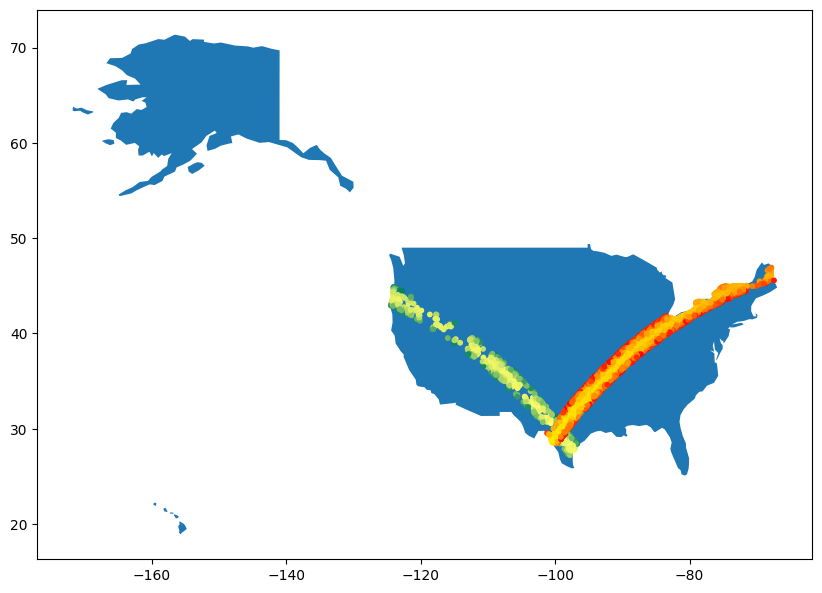

In [29]:
import geopandas as gpd
world = gpd.read_file("../../../ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# filter on US
us = world[world['CONTINENT'] == 'North America']
us = us[us['NAME'] == 'United States of America']

# plot US
fig, ax = plt.subplots(figsize=(10, 10))
us.plot(ax=ax)

# plot eclipses
for df in [df_2023, df_2024]:
    ax.scatter(
        df['lon'],
        df['lat'],
        color=df['color'],
        s=10,
        #transform=ccrs.PlateCarree()
    )

plt.show()

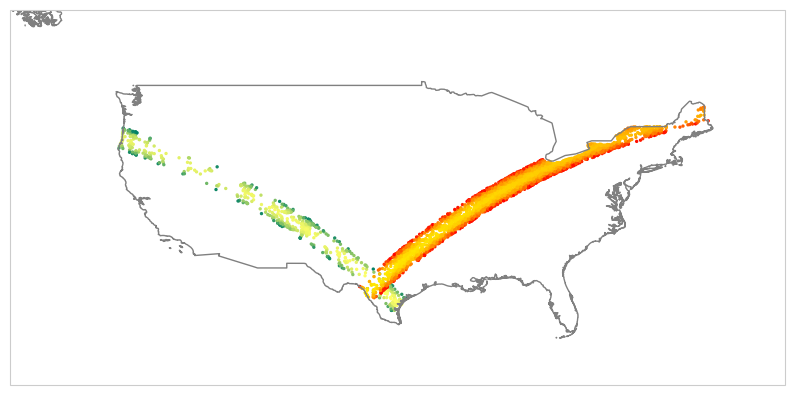

In [97]:
from cartopy.io import shapereader
import geopandas
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

poly = df.loc[df['ADMIN'] == 'United States of America']['geometry'].values[0]

fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.5')
ax.set_extent([-135, -60, 20, 50], crs=ccrs.Geodetic())
for df in [df_2023, df_2024]:
    ax.scatter(
        df['lon'],
        df['lat'],
        color=df['color'],
        s=2,
        transform=ccrs.PlateCarree()
    )